# Прогнозирование оттока клиентов банков с помощью бинарной классификации

## Шаг. 1. Загрузите и подготовьте данные. Поясните порядок действий.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('churn.csv')

In [3]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


df.corr()

In [6]:
df.duplicated().sum()

0

**Вывод:** Необходимо привести названия столбцов к нижнему регистру. Пропущены значения в столбце Tenure. В датасете 10 тысяч строк, что достаточно для качественного обучения моделей. Мультиколлинеарность не наблюдается. Явные дубликаты отсутствуют.

## Шаг 2. Предобработка данных

In [7]:
df.columns = map(str.lower, df.columns) # приводим названия столбцов к нижнему регистру

In [8]:
# разделим названия столбцов на отдельные слова нижним подчеркиванием 
df = df.rename(columns={'rownumber':'row_number', 'customerid':'customer_id', 'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})

In [9]:
df[df['tenure'].isna()] # рассмотрим подробнее пропуски в столбце Tenure

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [10]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
row_number,0.000000
customer_id,0.000000
surname,0.000000
credit_score,0.000000
geography,0.000000
gender,0.000000
age,0.000000
tenure,9.100000
balance,0.000000
num_of_products,0.000000


Поскольку пропусков в столбце более 5% мы не можем просто удалить строки с пропусками. Также нет никакой зависимости с дургими столбцами. Скорее всего произошли технические неполадки и данные удалились. Чтобы не "шокировать" будущую модель предлагается заменить пропуски медианными значениями. 

In [11]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())

In [12]:
df['tenure'].isna().sum()

0

In [13]:
# избавимся от столбцов row_number, customer_id, surname поскольку они не влияет на целевой признак
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [14]:
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [15]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

**Вывод:** Преобразованы названия столбцов, заменены пропуски значений в столбце tenure, удалены столбцы, которые не влияют на целевой признак. Категориальные столбцы gender и geography можно преобразовать в численные с помощью прямого кодирования.

## Шаг 3. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [16]:
# преобразование категориальных столбцов в цифровые
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [17]:
# Разделим датафрейм на признаки и целевой признак
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)

In [18]:
# сначала необходимо выделить тестовую выборку из всего датасета
features_1, features_test, target_1, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
# затем выделяем обучающую и валдиационную выборки из оставшегося датасета
features_train, features_valid, target_train, target_valid = train_test_split(features_1, target_1, test_size=0.25, random_state=12345, stratify=target_1)
pd.options.mode.chained_assignment = None

In [19]:
# производим стандартизацию численных значений
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
5536,-0.143332,0.577533,-0.001274,-1.220573,0.797767,1,1,1.029613,0,1,1
8530,1.632702,-0.564119,-1.092954,0.435807,-0.916018,1,0,0.237986,0,0,0
1762,1.116413,-0.468981,-1.456847,1.245822,-0.916018,1,1,-0.686104,0,0,0
9090,1.643028,0.006707,-0.001274,-1.220573,-0.916018,1,0,-0.391097,0,0,0
8777,-0.484083,-1.420358,-1.456847,1.421989,0.797767,1,0,-1.361559,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2956,1.467489,-0.849532,1.090407,-1.220573,0.797767,1,0,1.727827,0,0,1
667,-1.516661,-0.944670,-0.729060,-1.220573,0.797767,1,1,0.760116,0,0,1
7371,2.066384,-0.849532,1.818193,1.243157,0.797767,1,0,-0.649923,0,0,1
9472,1.291951,3.336526,-1.820741,1.361543,-0.916018,1,1,0.602245,1,0,0


In [20]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


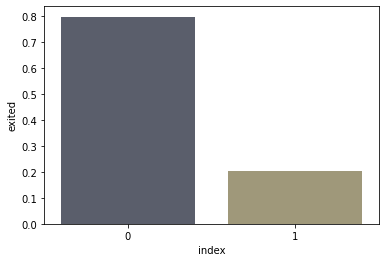

In [21]:
# рассмотрим баланс классов целевого признака
class_balance = target.value_counts(normalize=True).reset_index()
sns.barplot(y='exited', x='index', data=class_balance, palette='cividis');

Как видно из диаграммы, в данных наблюдается дисбаланс.

In [22]:
# создадим функцию для обучения моделей с помощью разных алгоритмов

def training(features_train, target_train, features_valid, target_valid):
    
    # обучение модели древа решений
    
    model_DT = DecisionTreeClassifier(random_state=12345)
    model_DT.fit(features_train, target_train)
    predictions_DT = model_DT.predict(features_valid)

    # обучение модели случайный лес
    
    model_RF = RandomForestClassifier(random_state=12345, n_estimators=100)
    model_RF.fit(features_train, target_train)
    predictions_RF = model_RF.predict(features_valid)

    # обучение модели логистической регресии
    
    model_LR = LogisticRegression(solver='liblinear')
    model_LR.fit(features_train, target_train)
    predictions_LR = model_LR.predict(features_valid)

    print(
        "F1-метрика для древа решений -", f1_score(target_valid, predictions_DT),
        ",", "матрица ошибок:", confusion_matrix(target_valid, predictions_DT)
    )
    
    print(
        "F1-метрика для cлучайного леса -", f1_score(target_valid, predictions_RF),
        ",", "матрица ошибок:", confusion_matrix(target_valid, predictions_RF)
    )
    
    print(
        "F1-метрика для логистической регрессии -", f1_score(target_valid, predictions_LR),
        ",", "матрица ошибок:", confusion_matrix(target_valid, predictions_LR)
    )

In [23]:
training(features_train, target_train, features_valid, target_valid)

F1-метрика для древа решений - 0.5000000000000001 , матрица ошибок: [[1367  226]
 [ 196  211]]
F1-метрика для cлучайного леса - 0.5555555555555556 , матрица ошибок: [[1532   61]
 [ 227  180]]
F1-метрика для логистической регрессии - 0.3214953271028037 , матрица ошибок: [[1551   42]
 [ 321   86]]


Вывод: Для создания качественной модели, подготовлены признаки: преобразованы категориальные столбцы в численные и масшатабированы признаки. В данных наблюдается дисбаланс классов. Обучены 3 модели без учета дисбаланса классов:
- Наивысшее значение f1-метрики показала модель RF, однако, алгоритм все равно имеет склонность к FN-ответам, что сильно понижает качетсво модели.
- Наихудшее значение f1-метрики показала модели LR, где еще больше FN-ответов, что приводит к тому, что положительные значения почти не могут быть предсказаны.

## Шаг 4. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

### Размер выборки

In [24]:
class_balance

,index,exited
0,0,0.7963
1,1,0.2037


В связи с соотношением отрицательного класса к положительному 4:1, необоходимо увеличить долю положительного класса в 4 раза.

In [25]:
# создадим функцию для реализации upsampling-a:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target ==0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [26]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [27]:
# проверим баланс классов после upsampling-a
target_upsampled.value_counts(normalize=1)

1    0.505947
0    0.494053
Name: exited, dtype: float64

### Обучение моделей с учетом дисбаланса классов

In [28]:
# создадим функцию для обучения моделей с помощью разных алгоритмов, для логистической регресии добавим аргумент class_weight 
def training_class_balanced(features_train, target_train, features_valid, target_valid):
    model_DT = DecisionTreeClassifier(random_state=12345)
    model_DT.fit(features_train, target_train)
    predictions_DT = model_DT.predict(features_valid)

    model_RF = RandomForestClassifier(random_state=12345, n_estimators=100)
    model_RF.fit(features_train, target_train)
    predictions_RF = model_RF.predict(features_valid)

    model_LR = LogisticRegression(solver='liblinear', class_weight='balanced')
    model_LR.fit(features_train, target_train)
    predictions_LR = model_LR.predict(features_valid)

    print("F1-метрика для древа решений -", f1_score(target_valid, predictions_DT), ",", "матрица ошибок:", confusion_matrix(target_valid, predictions_DT))
    print("F1-метрика для cлучайного леса -", f1_score(target_valid, predictions_RF), ",", "матрица ошибок:", confusion_matrix(target_valid, predictions_RF))
    print("F1-метрика для логистической регрессии -", f1_score(target_valid, predictions_LR), ",", "матрица ошибок:", confusion_matrix(target_valid, predictions_LR))

In [29]:
training_class_balanced(features_upsampled, target_upsampled, features_valid, target_valid)

F1-метрика для древа решений - 0.5 , матрица ошибок: [[1382  211]
 [ 201  206]]
F1-метрика для cлучайного леса - 0.5959183673469388 , матрица ошибок: [[1484  109]
 [ 188  219]]
F1-метрика для логистической регрессии - 0.5113043478260869 , матрица ошибок: [[1144  449]
 [ 113  294]]


По результату улучшения качества моделей увеличилась и f1-метрика. Больше всего метрика поднялась у логистической регрессии, а нивысшее значение все также у алгоритма случайного леса.

### Сравнение качества модели RF со случайной моделью

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC

In [30]:
model_RF = RandomForestClassifier(random_state=12345, n_estimators=100)
model_RF.fit(features_upsampled, target_upsampled)
predictions_RF = model_RF.predict(features_valid)

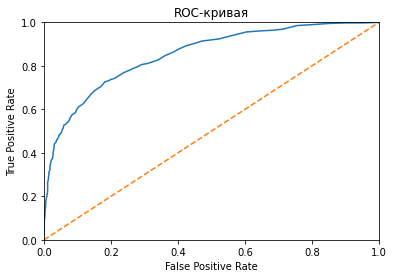

In [31]:
# пострим ROC-кривую
probabilities_valid = model_RF.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [32]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.851502504044877

Как видно из графика метрика AUC-ROC больше, чем у случайной модели, но до идельного значения еще далеко (AUC-ROC = 1)

### Подбор гиперпараметров для улучшения F1-меры

In [33]:
best_result = 0
for est in tqdm(range(1, 101, 10)):
    for depth in range(1, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions) 
        if result > best_result:
            best_model_RF = model
            best_result = result
            best_depth = depth
            best_est = est
print("Наивысшее значение f1-меры = ", best_result)
print("Наивысшее значение f1-меры при depth = ", best_depth)
print("Наивысшее значение f1-меры при n_est = ", best_est)

100%|██████████| 10/10 [01:02<00:00,  6.30s/it]

Наивысшее значение f1-меры =  0.6348448687350835
Наивысшее значение f1-меры при depth =  12
Наивысшее значение f1-меры при n_est =  91


### Подбор оптимального порога классификации

In [34]:
probabilities_valid = best_model_RF.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | f1 = {:.3f}".format(
        threshold, f1))

Порог = 0.00 | f1 = 0.338
Порог = 0.05 | f1 = 0.364
Порог = 0.10 | f1 = 0.403
Порог = 0.15 | f1 = 0.442
Порог = 0.20 | f1 = 0.482
Порог = 0.25 | f1 = 0.522
Порог = 0.30 | f1 = 0.551
Порог = 0.35 | f1 = 0.576
Порог = 0.40 | f1 = 0.600
Порог = 0.45 | f1 = 0.612
Порог = 0.50 | f1 = 0.635
Порог = 0.55 | f1 = 0.625
Порог = 0.60 | f1 = 0.603
Порог = 0.65 | f1 = 0.586
Порог = 0.70 | f1 = 0.544
Порог = 0.75 | f1 = 0.507
Порог = 0.80 | f1 = 0.451
Порог = 0.85 | f1 = 0.388
Порог = 0.90 | f1 = 0.269
Порог = 0.95 | f1 = 0.071


Лучшее значение f1-меры показывает порог классификации равный 0.5, т.e. оставляем значени по умолчанию.

Вывод: 
- Улучшено качство модели с помощью upsampling
- Обучена модель с учетом дисбаланса классов,  f1-мера увеличилась, что говорит об эффективности проделанных действий. Наилучшей моделью оказалась модель случайного леса. Далее будем работать только с одной моделью.
- Качество метрики AUC-ROC выше, чем у случайной модели и составляет 0.844
- Подобрали оптимальные гиперпараметры для максимизации f1-меры : max_depth = 16, n_estimators = 91.

## Шаг 5. Проведите финальное тестирование.

### Оценка F1-меры для тестовой выборки

In [35]:
# проведем оценку f1-меры на тестовой выборке
predictions_test = best_model_RF.predict(features_test)
f1_test = f1_score(target_test, predictions_test)
f1_test

0.6125290023201856

Значение F1-меры выше порогового значения.

### Сравнение метрик с константной моделью

In [36]:
# создадим константную модель 
predictions_const = pd.Series([0]*len(target_test))
predictions_const.value_counts()


0    2000
dtype: int64

In [37]:
def final_comparison(target, predictions):
    accuracy = accuracy_score(target, predictions)
    auc_roc = roc_auc_score(target, predictions)
    print("Accuracy равна", accuracy, ",", "AUC-ROC равна", auc_roc)

In [38]:
# Метрики accuracy и AUC-ROC для константной модели
final_comparison(target_test, predictions_const)

Accuracy равна 0.7965 , AUC-ROC равна 0.5


In [39]:
# Метрики accuracy и AUC-ROC для финальной модели
predictions_best_model_RF = best_model_RF.predict(features_test)
final_comparison(target_test, predictions_best_model_RF)

Accuracy равна 0.833 , AUC-ROC равна 0.7643745440355609


Сравнив полученную финальную модель с константной, делаем вывод о том, что модель имеет место быть и лучше использовать её для предсказания оттока клиентов, чем более простую константную модель.

**Общий вывод:** 
- Загружены и проанализированы данные о поведении пользователей "Бета-Банка".
- Данные приведены к виду, в котором можно качественно строить модели машинного обучения
- Построены модели машинного обучения с учетом и без учета дисбаланса классов. При учитывании дисбаланса классов модели имеют f1-меру выше.
- Для улучшении качества модели произведен upsampling, выбрана наилучшая модель (случайный лес) и подобраны гиперпараметры для максимизации f1-меры.
- Сравнили получвшуюся финальную модель с константной, тем самым удостоверившись в том, что модель рабочая
- Получившая f1-мера выше пороговой (0.59) и составляет 0.61 на тестовой выборке.


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Спасибо еще раз ревью. Советы все по делу, постараюсь учесть в будущих проектах! </font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Был рад совместной работе, Кирилл!
</div>